## Cristina Butucea  
2025–2026  

## Implementing Fair Classification in Python

### Dataset

We will use the public **ACS Income** dataset.  
See more on *Fairlearn.org*.  
- Protected attribute: **sex**
- Target variable: **PINCP**

1. Load and inspect the dataset.

2. Pre-process the dataset: remove missing data, separate the income variable into array **y** and the other variables into array **X**. Split into train and test samples.

3. Train a regression estimator and the Bayes plug-in classifier. Measure fairness metrics such as demographic parity difference and equalized odds. Calculate its accuracy for classification.

4. Implement the fair classifier under demographic parity studied in class. Measure its demographic parity. Calculate the same accuracy for this classifier.

5. Compare fairness vs. accuracy trade-offs.

6. The **Fairlearn** Python library proposes a post-processing method to numerically adjust the best threshold under a given fairness constraint. Implement **ThresholdOptimize** on the dataset and compare the results.


In [ ]:
# from fairlearn.datasets import fetch_acs_income
# import pandas as pd

# # Load dataset
# data = fetch_acs_income()

# print(data.keys())

# df = pd.DataFrame(data.data, columns=data.feature_names)

# labels = pd.Series(data.target, name="PINCP")

# # Join features and labels into a single DataFrame
# df['PINCP'] = labels

# df.head()

In [ ]:
# # save to csv
# df.to_csv('data/acs_income.csv', index=False)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [1]:
import numpy as np
import pandas as pd

# load dataset
df = pd.read_csv('data/acs_income.csv')
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,ST,PINCP
0,18.0,1.0,18.0,5.0,4720.0,13.0,17.0,21.0,2.0,2.0,NaN,1600.0
1,53.0,5.0,17.0,5.0,3605.0,18.0,16.0,40.0,1.0,1.0,NaN,10000.0
2,41.0,1.0,16.0,5.0,7330.0,1.0,17.0,40.0,1.0,1.0,NaN,24000.0
3,18.0,6.0,18.0,5.0,2722.0,1.0,17.0,2.0,2.0,1.0,NaN,180.0
4,21.0,5.0,19.0,5.0,3870.0,12.0,17.0,50.0,1.0,1.0,NaN,29000.0


In [3]:
df.shape

(1664500, 12)

In [4]:
# missing valuse
df.isna().sum().sort_values(ascending=False)

ST       1664500
AGEP           0
COW            0
SCHL           0
MAR            0
OCCP           0
POBP           0
RELP           0
WKHP           0
SEX            0
RAC1P          0
PINCP          0
dtype: int64

In [ ]:
# drop st columns
df = df.drop(columns=['ST'])

df.isna().sum().sum()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664500 entries, 0 to 1664499
Data columns (total 11 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   AGEP    1664500 non-null  float64
 1   COW     1664500 non-null  float64
 2   SCHL    1664500 non-null  float64
 3   MAR     1664500 non-null  float64
 4   OCCP    1664500 non-null  float64
 5   POBP    1664500 non-null  float64
 6   RELP    1664500 non-null  float64
 7   WKHP    1664500 non-null  float64
 8   SEX     1664500 non-null  float64
 9   RAC1P   1664500 non-null  float64
 10  PINCP   1664500 non-null  float64
dtypes: float64(11)
memory usage: 139.7 MB


In [ ]:
# unique values per column
df.nunique().sort_values(ascending=False)

PINCP    18107
OCCP       529
POBP       224
WKHP        99
AGEP        80
SCHL        24
RELP        18
RAC1P        9
COW          8
MAR          5
SEX          2
dtype: int64

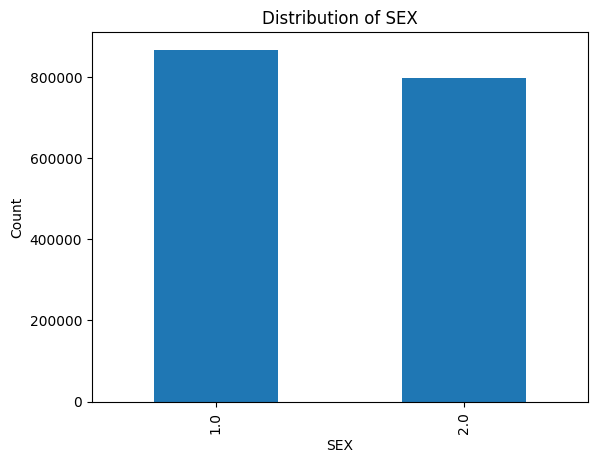

In [15]:
# plot SEX distribution
import matplotlib.pyplot as plt

df['SEX'].value_counts().plot(kind='bar')
plt.xlabel('SEX')
plt.ylabel('Count')
plt.title('Distribution of SEX')
plt.show()

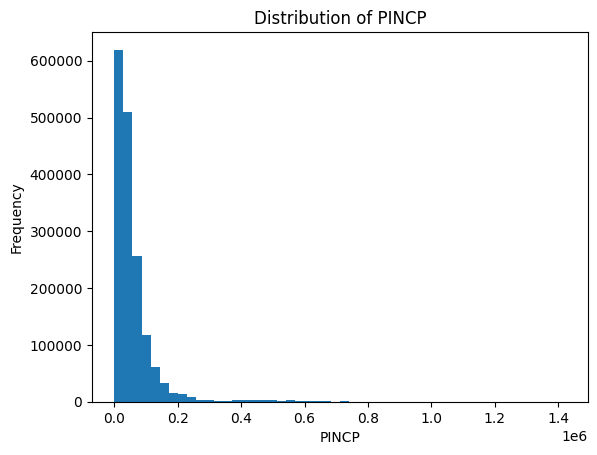

In [16]:
# plot distribution of PINCP
plt.hist(df['PINCP'], bins=50)
plt.xlabel('PINCP')
plt.ylabel('Frequency')
plt.title('Distribution of PINCP')
plt.show()

In [17]:
df['PINCP'].describe()

count    1.664500e+06
mean     5.666386e+04
std      7.306745e+04
min      1.040000e+02
25%      2.000000e+04
50%      3.900000e+04
75%      6.800000e+04
max      1.423000e+06
Name: PINCP, dtype: float64

In [13]:
# seperate features and labels
X = df.drop(columns=['PINCP'])
y = df['PINCP']

X.shape, y.shape

((1664500, 10), (1664500,))

In [14]:
# split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1331600, 10), (332900, 10), (1331600,), (332900,))

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# predict on test set
y_pred_lr = lr_model.predict(X_test)

# evaluate the model
r2_lr = r2_score(y_test, y_pred_lr)
print(f'Linear Regression R2: {r2_lr}')

Linear Regression R2: 0.24163037446957514


In [ ]:
# define threshold for classification
threshold = y.median()

# convert reg pred and test to binary classification
y_pred_class = (y_pred_lr >= threshold).astype(int)
y_test_class = (y_test >= threshold).astype(int)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# evaluate classification metrics
lr_clf_accuracy = accuracy_score(y_test_class, y_pred_class)
print(f'Accuracy: {lr_clf_accuracy}')

Accuracy: 0.7234604986482427


In [25]:
from sklearn.linear_model import LogisticRegression

# define y_train clf
y_train_bin = (y_train >= threshold).astype(int)

# Bayes Plug-in Classifier (Logistic Regression)
clf_model = LogisticRegression()
clf_model.fit(X_train, y_train_bin)

# Probability estimates P(Y=1 | X)
y_prob_clf = clf_model.predict_proba(X_test)[:, 1]

# Class prediction at 0.5 threshold
y_pred_clf = (y_prob_clf >= 0.5).astype(int)

In [26]:
# evaluate classification metrics
clf_accuracy = accuracy_score(y_test_class, y_pred_clf)
print(f'Logistic Regression Classifier Accuracy: {clf_accuracy}')

Logistic Regression Classifier Accuracy: 0.726984079303094


### Fairness metrics

In [ ]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score

In [34]:
import numpy as np

def demographic_parity_difference_manual(y_pred, A):
    y_pred = np.asarray(y_pred)
    A = np.asarray(A)

    rates = []

    for group in np.unique(A):
        mask = (A == group)
        # Positive prediction rate in this group
        rate = y_pred[mask].mean()   # mean of 0/1 is just proportion of 1s
        rates.append(rate)

    return max(rates) - min(rates)


In [ ]:
import numpy as np
import itertools

def equalized_odds_difference_manual(y_true, y_pred, A):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    A = np.asarray(A)

    tprs = {}
    fprs = {}

    for group in np.unique(A):
        mask = (A == group)
        yt = y_true[mask]
        yp = y_pred[mask]

        # TPR: P(pred=1 | true=1, group)
        positives = (yt == 1)
        if positives.any():
            tpr = (yp[positives] == 1).mean()
        else:
            tpr = 0.0  # or np.nan, if you prefer
        tprs[group] = tpr

        # FPR: P(pred=1 | true=0, group)
        negatives = (yt == 0)
        if negatives.any():
            fpr = (yp[negatives] == 1).mean()
        else:
            fpr = 0.0
        fprs[group] = fpr

    # Now compute the maximum difference across groups
    diffs = []
    groups = list(tprs.keys())
    for g1, g2 in itertools.combinations(groups, 2):
        diffs.append(abs(tprs[g1] - tprs[g2]))
        diffs.append(abs(fprs[g1] - fprs[g2]))

    return max(diffs)


In [38]:
# define sensitive feature
sex_test = X_test['SEX']

# Use scikit-learn and fairlearn metrics
dp_clf = demographic_parity_difference(y_test_class, y_pred_clf, sensitive_features=sex_test)
eo_clf = equalized_odds_difference(y_test_class, y_pred_clf, sensitive_features=sex_test)
acc_clf = accuracy_score(y_test_class, y_pred_clf)

print("Bayes (logistic regression) classifier:")
print("  Demographic Parity Difference:", dp_clf)
print("  Equalized Odds Difference:", eo_clf)
print("  Accuracy:", acc_clf)


Bayes (logistic regression) classifier:
  Demographic Parity Difference: 0.05680718703941823
  Equalized Odds Difference: 0.04860428080907869
  Accuracy: 0.726984079303094


In [39]:
# Manual calculations
dp_clf_manual = demographic_parity_difference_manual(y_pred_clf, sex_test)
eo_clf_manual = equalized_odds_difference_manual(y_test_class, y_pred_clf, sex_test)
print("Manual calculations:")
print("  Demographic Parity Difference:", dp_clf_manual)
print("  Equalized Odds Difference:", eo_clf_manual)


Manual calculations:
  Demographic Parity Difference: 0.05680718703941823
  Equalized Odds Difference: 0.04860428080907869


### Question 4

In [40]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train_bin)

# predicted probability scores
y_prob_test = clf.predict_proba(X_test)[:, 1]


In [ ]:
import numpy as np

# get predicted probabilities by group
prob_group0 = y_prob_test[sex_test == 0]
prob_group1 = y_prob_test[sex_test == 1]

# compute desired positive rate = average of two groups
# (you can choose other targets, but this is the standard classroom version)
rate0 = np.mean(y_test_class[sex_test == 0])
rate1 = np.mean(y_test_class[sex_test == 1])

target_rate = (rate0 + rate1) / 2

# Compute thresholds that achieve this rate in each group
thr0 = np.quantile(prob_group0, 1 - target_rate)
thr1 = np.quantile(prob_group1, 1 - target_rate)

print("Threshold group 0:", thr0)
print("Threshold group 1:", thr1)


ValueError: Quantiles must be in the range [0, 1]

In [ ]:
y_pred_fair = np.zeros_like(y_prob_test)

mask0 = (sex_test == 0)
mask1 = (sex_test == 1)

y_pred_fair[mask0] = (y_prob_test[mask0] >= thr0).astype(int)
y_pred_fair[mask1] = (y_prob_test[mask1] >= thr1).astype(int)


In [ ]:
dp_fair = demographic_parity_difference(
    y_test_class, y_pred_fair, sensitive_features=sex_test
)
print("DP (fair classifier):", dp_fair)
